In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn
%matplotlib inline

In [ ]:
torch.cuda.set_device(0)

In [2]:
path_img = Path('anime-sketch-split/timg/kaggle/working/train/Images')
path_sktch = Path('anime-sketch-split/tsktch/kaggle/working/train/Sketches')

In [3]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8200: bs,size=16,256  
else:           bs,size=8,256
print(f"using bs={bs}, size={size}, have {free}MB of GPU RAM free")

arch = models.resnet34
# sample = 0.1
sample = False

tfms = get_transforms()

using bs=8, size=256, have 0MB of GPU RAM free


In [4]:
sktch = ImageImageList.from_folder(path_sktch)
img = ImageImageList.from_folder(path_img)

In [5]:
sktch = sktch.split_by_rand_pct(0.1, seed=42)

In [6]:
bs = 16
size = 256

In [7]:
def get_data(bs,size):
    data = (sktch.label_from_func(lambda x: path_img/x.relative_to(path_sktch))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

In [9]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [10]:
vgg_m = vgg16_bn(True).features.eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [11]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [12]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [19]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect()

60

In [20]:
learn.load('1a')

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: anime-sketch-split/tsktch/kaggle/working/train/Sketches;

Valid: LabelList (1000 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: anime-sketch-split/tsktch/kaggle/working/train/Sketches;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3,

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save('/kaggle/working/'+save_name)
    learn.show_results(rows=1, imgsize=5)

In [ ]:
do_fit('1a', slice(lr*10))

In [22]:
learn.export('export.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


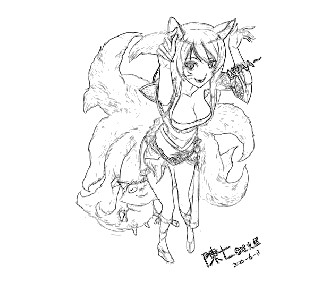

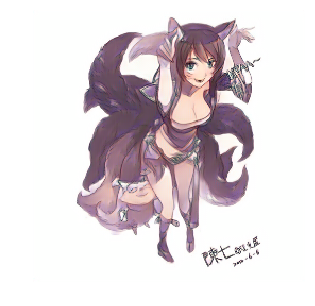

In [28]:
img = open_image('anime-sketch-split/val/kaggle/working/val/Sketches/{0}'.format(random.sample(os.listdir('anime-sketch-split/val/kaggle/working/val/Sketches'), 1)[0]))
_,img_hr,b = learn.predict(img)
show_image(img, figsize=(5, 5))
Image(img_hr).show(figsize=(5,5))